# Deep Learning - Exercise 2
# 🧠 Collaborative Filtering with Gradient Descent
### Implementing Matrix Factorization from Scratch

## 📘 Introduction

Recommender systems are one of the most practical applications of machine learning — they power movie recommendations on Netflix, product suggestions on Amazon, and playlist generation on Spotify.  
A key technique behind many of these systems is **collaborative filtering**.

---

### 🎯 The Idea

Collaborative filtering assumes that similar users tend to like similar items.  
Instead of explicitly learning about the *content* (e.g., the genre of a movie), we use **patterns in user–item interactions** (like ratings or clicks) to make predictions.

We start with a matrix of ratings:

| User | Item 1 | Item 2 | Item 3 | Item 4 |
|------|--------|--------|--------|--------|
| A    | 5      | 3      | ?      | 1      |
| B    | 4      | ?      | ?      | 1      |
| C    | 1      | 1      | ?      | 5      |
| D    | ?      | ?      | 5      | 4      |

Our goal is to **predict the missing values** (the `?` entries).

---

### ⚙️ The Model

We assume each user and each item can be represented by a vector of hidden “features” (called **latent factors**).  
For example, in a movie dataset, latent factors might represent things like *action vs. drama*, *comedy*, or *romantic themes*.

We learn two matrices:

- $P$: user feature matrix (users × k)
- $Q$: item feature matrix (items × k)

Their product approximates the rating matrix:

$$
\hat{R} = P Q^T
$$

---

### 📉 The Optimization Problem

We want to find $P$ and $Q$ that minimize the difference between the known ratings and the predicted ones:

$$
\min_{P, Q} \sum_{(u, i) \in \Omega} (R_{ui} - P_u^T Q_i)^2
$$

where $\Omega$ is the set of known ratings.

We’ll solve this minimization using **gradient descent** — iteratively updating $P$ and $Q$ to reduce the total error.

---

### 🚀 Goal of This Exercise

By the end of this notebook, you will:
- Understand how collaborative filtering works mathematically.  
- Implement it **from scratch using NumPy**.  
- Train a small recommender model using **gradient descent**.  
- Visualize how the loss decreases during training.  

This will give you a deep understanding of how modern recommender systems (like Matrix Factorization in Netflix or implicit-feedback models) are built at their core.

## 📤 How to Submit
Submit **only** this notebook including your code in it, through the course system. Look for "# Your code here" for the places you need to add your code to the solution.


# Implementation

In [2]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# The data

Download movie ratings data:

In [1]:
import urllib.request
import zipfile
import os

# Download the dataset
url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
zip_filename = "ml-100k.zip"

if not os.path.exists("ml-100k"):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_filename)
    
    # Unzip it
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(".")
    
    # Get rid of the .zip file
    os.remove(zip_filename)
    print("Dataset ready!")
else:
    print("Dataset already exists, skipping download.")

zsh:1: command not found: wget
unzip:  cannot find or open ml-100k.zip, ml-100k.zip.zip or ml-100k.zip.ZIP.
rm: ml-100k.zip: No such file or directory


In [4]:
ratings = pd.read_csv(
    "ml-100k/u.data",
    sep="\t", # this is a tab separated data
    names=["user_id", "movie_id", "rating", "timestamp"], # the columns names
    usecols=["user_id", "movie_id", "rating"], # we do not need the timestamp column
    low_memory=False
)
ratings

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


Split to train and test sets:

In [5]:
test_perc = 0.2

# Initialize the train and test dataframes.
train_set, test_set = pd.DataFrame(), pd.DataFrame()

# Check each user.
for user_id in ratings.user_id.unique():
    user_df = ratings[ratings.user_id == user_id].sample(
        frac=1,
        random_state=42
    ) # select only samples of the actual user and shuffle the resulting dataframe

    n_entries = len(user_df)
    n_test = int(round(test_perc * n_entries))

    test_set = pd.concat((test_set, user_df.tail(n_test)))
    train_set = pd.concat((train_set, user_df.head(n_entries - n_test)))

train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)

train_set.shape, test_set.shape

((80000, 3), (20000, 3))

Compute the dimensions of the matrix/problem:

In [6]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
n_users, n_movies

(943, 1682)

# Computing the function (hypothesis)

In [25]:
class H:
  def __init__(self, n, m, r):
    # n: number of users
    # m: number of movies/items
    # r: number of latent factors
    # Initialize user feature matrix P (n × r) and item feature matrix Q (m × r)
    np.random.seed(42)  # For reproducibility
    self.P = np.random.randn(n, r)  # User features: n users × r factors
    self.Q = np.random.randn(m, r)  # Item features: m items × r factors
    self.n = n
    self.m = m
    self.r = r

  def predict(self):
    # Return the predicted rating matrix: R_hat = P @ Q^T
    # This gives an n × m matrix where R_hat[i, j] is the predicted rating
    # for user i and item j
    return self.P @ self.Q.T


# The error function

Implement squared error

In [26]:
def mse(ratings, R_hat):
  # Compute mean squared error between actual ratings and predicted ratings
  # ratings: DataFrame with columns ['user_id', 'movie_id', 'rating']
  # R_hat: predicted rating matrix (n_users × n_movies)
  # Note: user_id and movie_id are 1-indexed, but R_hat is 0-indexed
  
  squared_errors = []
  for _, row in ratings.iterrows():
    user_id = int(row['user_id'])
    movie_id = int(row['movie_id'])
    actual_rating = row['rating']
    
    # Get predicted rating (subtract 1 because user_id and movie_id are 1-indexed)
    predicted_rating = R_hat[user_id - 1, movie_id - 1]
    
    # Compute squared error
    squared_error = (actual_rating - predicted_rating) ** 2
    squared_errors.append(squared_error)
  
  # Return mean of squared errors
  return np.mean(squared_errors)

In [27]:
h = H(n_users, n_movies, 5)
mse(train_set, h.predict())

np.float64(18.848879634780324)

# Training

### Computing the gradient

In [28]:
import sympy as sp

n = 3
a = sp.Symbol('a')

x = sp.Matrix(sp.symbols(f'x0:{n}'))
y = sp.Matrix(sp.symbols(f'y0:{n}'))

f = (x.dot(y) - a)**2

grad_x = sp.Matrix([sp.diff(f, xi) for xi in x])
grad_y = sp.Matrix([sp.diff(f, yi) for yi in y])

print("∇x f =")
sp.pprint(grad_x)
print("\n∇y f =")
sp.pprint(grad_y)

∇x f =
⎡2⋅y₀⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎤
⎢                                 ⎥
⎢2⋅y₁⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎥
⎢                                 ⎥
⎣2⋅y₂⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎦

∇y f =
⎡2⋅x₀⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎤
⎢                                 ⎥
⎢2⋅x₁⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎥
⎢                                 ⎥
⎣2⋅x₂⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎦


In [29]:
import sympy as sp

x, y, a = sp.symbols('x y a', real=True)

f = (x * y - a)**2

grad_x = sp.diff(f, x)
grad_y = sp.diff(f, y)

sp.pprint(grad_x)
sp.pprint(grad_y)

2⋅y⋅(-a + x⋅y)
2⋅x⋅(-a + x⋅y)


In [30]:
def update_gradient(h, ratings, lr):
  # Update P and Q matrices using gradient descent
  # For each rating (user_id, movie_id, rating), compute the gradient and update
  # Based on the gradient: ∇P[u] = 2 * Q[i] * (predicted - actual)
  #                        ∇Q[i] = 2 * P[u] * (predicted - actual)
  # For gradient descent: param = param - lr * gradient
  
  for _, row in ratings.iterrows():
    user_id = int(row['user_id'])
    movie_id = int(row['movie_id'])
    actual_rating = row['rating']
    
    # Convert to 0-indexed
    u = user_id - 1
    i = movie_id - 1
    
    # Get current feature vectors
    P_u = h.P[u]  # User u's feature vector (r dimensions)
    Q_i = h.Q[i]  # Item i's feature vector (r dimensions)
    
    # Compute predicted rating: P[u] @ Q[i]^T = P[u] · Q[i]
    predicted_rating = np.dot(P_u, Q_i)
    
    # Compute error: actual - predicted
    error = actual_rating - predicted_rating
    
    # Compute gradients (from sympy: 2*y*(predicted - actual) = -2*y*error)
    # For gradient descent, we subtract the gradient: param = param - lr * gradient
    # So: param = param - lr * (-2 * vector * error) = param + lr * 2 * vector * error
    gradient_P_u = 2 * Q_i * error
    gradient_Q_i = 2 * P_u * error
    
    # Update P[u] and Q[i] using gradient descent
    h.P[u] += lr * gradient_P_u
    h.Q[i] += lr * gradient_Q_i

### The algorithm - gradient descent

In [31]:
epochs = 100
lr = 0.001

In [32]:
# Your code here
# Gradient descent training loop
# For each epoch, update the model parameters using the training set

for epoch in range(epochs):
    # Update P and Q matrices using gradient descent on the training set
    update_gradient(h, train_set, lr)
    
    # Optionally print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        train_mse = mse(train_set, h.predict())
        print(f"Epoch {epoch + 1}/{epochs}, Train MSE: {train_mse:.4f}")

print("Training complete!")


Epoch 10/100, Train MSE: 1.6644
Epoch 20/100, Train MSE: 1.0046
Epoch 30/100, Train MSE: 0.8898
Epoch 40/100, Train MSE: 0.8418
Epoch 50/100, Train MSE: 0.8142
Epoch 60/100, Train MSE: 0.7951
Epoch 70/100, Train MSE: 0.7802
Epoch 80/100, Train MSE: 0.7678
Epoch 90/100, Train MSE: 0.7568
Epoch 100/100, Train MSE: 0.7471
Training complete!


# Testing

In [18]:
# Test with the test set
mse(test_set, h.predict())

np.float64(0.9980466308630112)

In [ ]:
s = []
for _, user_id, movie_id, rating in test_set.itertuples():
  s.append(abs(round(h.predict()[user_id-1, movie_id-1]) - rating))

In [20]:
S = pd.Series(s)
S.describe()

count    20000.00000
mean         0.73765
std          0.73624
min          0.00000
25%          0.00000
50%          1.00000
75%          1.00000
max          6.00000
dtype: float64

<Axes: ylabel='Frequency'>

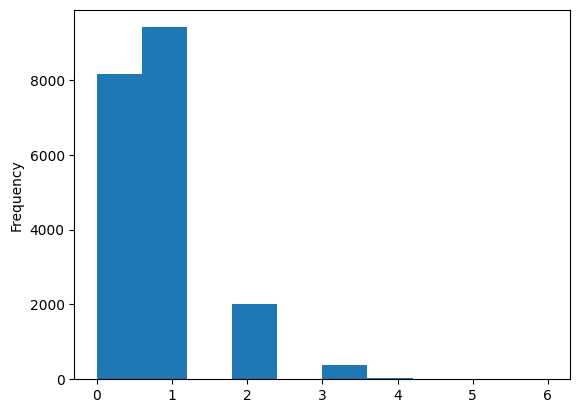

In [21]:
S.plot(kind='hist', bins=10)

In [22]:
S.value_counts()

1    9408
0    8163
2    2005
3     377
4      34
5      10
6       3
Name: count, dtype: int64

In [23]:
# The different values in round(h.predict())
np.unique(np.round(h.predict()))

array([-11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,
        -0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.])

# Movies properties

If you want to dive deeper...

In [ ]:
import pandas as pd

# Column names as given by MovieLens
columns = [
    "movie_id", "title", "release_date", "video_release_date", "IMDb_URL",
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
    "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

# Read u.item
df_items = pd.read_csv(
    "ml-100k/u.item",
    sep="|",
    names=columns,
    encoding="ISO-8859-1"
)

print(df_items.head())

   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1           1  ...        0          0       0        0